# Clustering
Denne innleveringen omhandler "clustering" eller "klynging", som er en form for
"unsupervised learning". Dette temaet er presentert i videoer relatert til denne
modulen, og beskrives ikke i detalj her i selve oppgave-notebook'en. 

Oppgavene du skal løse fungerer som små byggeblokker eller steg på veien som til slutt
kombineres til en fungerende clustering-algoritme (K-means). Vær litt obs på dette - du
skal "gjenbruke" funksjonene fra de første oppgavene i de senere oppgavene.  

Vi importerer først modulene vi trenger:

In [63]:
# Imports
import numpy as np  # For vectors and matrices
import random
from numpy.typing import NDArray
import ipytest
import csv
import matplotlib.pyplot as plt
import pytest
import sklearn.datasets
import sklearn.metrics

In [64]:
# Set up pytest for Jupyter notebooks
ipytest.autoconfig()

## Oppgave 1: Distanse-funksjon
Implementer en funksjon som beregner den Euklidske distansen mellom 2 vektorer.
Vektorene kan et villkårlig antall elementer/"dimensjoner" (2,3, eller flere). 

In [65]:
def distance(a: NDArray, b: NDArray) -> float:
    """Calculate Euclidian distance between two vectors

    Parameters
    ----------
    a: NDArray
        First vector (NumPy array)
    b: NDArray
        Second vector (NumPy array), same length as a

    Returns
    -------
    d : float
        Euclidian distance between a and b

    """
    if a.shape != b.shape:
        return -1
        
    d = 0
    for col in range(0, len(a)):
        d += ((a[col]- b[col])**2)
      
    d = d**0.5
    return d


In [66]:
%%ipytest


def test_distance():
    """Test calculation of distance for vectors of different lengths"""
    assert distance(np.array([7]), np.array([4])) == 3.0  # 1D
    assert distance(np.array([6, 4]), np.array([2, 1])) == 5.0  # 2D
    assert distance(np.array([-4, 7, 5.5]), np.array([2, 3.14, 9])) == pytest.approx(
        7.9466722
    )  # 3D
    assert distance(
        np.array([99.7, -29, -77.3, 35]), np.array([50.1, 70.2, 75.9, -33.33])
    ) == pytest.approx(201.097063)  # 4D


.                                                                                            [100%]
1 passed in 0.01s


## Oppgave 2: Finne nærmeste punkt
Implementer en funksjon som finner tar utgangspunkt i et datapunkt $x$, sammenligner det
med flere datapunkter samlet i ei matrise $C$, og som så returnerer indeks til punktet i $C$ som
ligger nærmest $x$.

In [67]:
def closest_point_index(x: NDArray, C: NDArray) -> int:
    """Find index of closest point in vector space

    Parameters
    ----------
    x: NDArray
        NumPy vector, shape (N,)
    C: NDArray
        NumPy matrix, shape (k,N), corresponding to k row vectors
        with the same length as x

    Returns
    -------
    i: int
        Index of row vector in C which is closest to x
        Index is in range [0,1,...,k-1].
    """

    import math
    d = math.inf
    i=0
    for N in range(0, len(C)):
        cur_d = 0
        for k in range(0, len(x)):
            cur_d += distance(x, C[N])
        cur_d = cur_d**0.5

        if d > cur_d:
            d = cur_d
            i = N

    return i

In [68]:
%%ipytest


def test_closest_point_index():
    """Test calculation of which point in C is closest to point x"""
    # k=2, N=2
    x = np.array([2, 2])
    C = np.array([[0, 0], [3, 3]])
    assert closest_point_index(x, C) == 1

    # k=3, N=3
    x = np.array([2, 5, 4])
    C = np.array([[3, 4, 5], [0, 1, 0], [2, 5, -4]])
    assert closest_point_index(x, C) == 0

    # k=5, N=4
    x = np.array([4.5, 8.8, 3.0, 6.4])
    C = np.array(
        [
            [8.0, 9.52, 3.16, 5.4],
            [2.9, 8.52, 2.19, 5.97],
            [5.43, 9.4, 3.18, 5.29],
            [2.4, 14.34, 1.84, 9.97],
            [2.95, 8.79, 1.89, 8.22],
        ]
    )
    assert closest_point_index(x, C) == 2

.                                                                                            [100%]
1 passed in 0.01s


## Oppgave 3: Velge tilfeldige punkter
K-means-algoritmen trenger noen tilfeldige datapunkter fra datasettet før den kan
begynne å iterere seg mot en ferdig klynging. Implementer en funksjon som velger $k$
tilfeldige datapunkter fra ei datamatrise $X$ (uten tilbakelegging).

In [69]:
def choose_random_points(X: NDArray, k: int) -> NDArray:
    """Randomly choose k row vectors from matrix

    Parameters
    ----------
    X: NDArray
        NumPy matrix of shape (M,N) (M row vectors of length N)
    k: int
        Number of vectors to choose at random (integer)

    Returns
    -------
    C: NDArray
        Subset of X, containing k randomly chosen row vectors.
        Shape (k,N).

    Raises
    ------
    ValueError
        Vectors are chosen without replacement. Using a k larger than the
        number of vectors in X raises a ValueError.
    """
    temp_x = X
    C = np.zeros((k, len(X[0])))

    for i in range(k):
        random_number = random.randint(0, len(temp_x)-1)
        C[i] = temp_x[random_number]
        temp_x = np.delete(temp_x, random_number, axis=0)
    return C

In [70]:
%%ipytest


def test_choose_random_points_1():
    """Check that k unique rows have been randomly selected"""
    k = 9
    X = np.random.standard_normal(size=(10, 2))
    C = choose_random_points(X, k=k)
    assert all(
        [row in X.tolist() for row in C.tolist()]
    )  # Check that every row in C is in X
    assert len(np.unique(C, axis=0)) == 9  # Check that every row is unique


def test_choose_random_points_2():
    """Check that returned subset is not always the same"""
    k = 3
    X = np.random.standard_normal(size=(20, 2))
    C1 = choose_random_points(X, k=k)
    C2 = choose_random_points(X, k=k)
    assert ~np.all(C1 == C2)


def test_choose_random_points_3():
    """Check that a ValueError is raised if k is too large"""
    k = 9
    X = np.random.standard_normal(size=(8, 2))
    with pytest.raises(ValueError):
        C = choose_random_points(X, k=k)


...                                                                                          [100%]
3 passed in 0.02s


## Oppgave 4: Finn nærmeste tyngdepunkt for alle datapunkter
Implementer en funksjon som går gjennom alle datapunktene i ei datamatrise $X$,
sammenligner hvert datapunkt med et sett med tyngdepunkter $C$, og finner indeks til
tyngdepunktet som ligger nærmest datapunktet. 

In [71]:
def find_closest_centroid(X: NDArray, C: NDArray) -> NDArray:
    """Find index to closest centroid for every datapoint

    Parameters
    ----------
    X: NDArray
        NumPy matrix of shape (M,N) (M row vectors of length N)
    C: NDArray
        NumPy matrix of shape (k,N), representing centroids
        for k clusters.

    Returns
    -------
    y: NDArray
        NumPy vector, shape (M,), with values in range [0,1,...,k-1].
        y represents a "cluster index" for each data point in X.
        If X[i,:] is closest to centroid C[j,:], then y[i] = j.
        y has an integer data type.
    """
    import math
    M = X.shape[0]
    N = X.shape[1]
    k = C.shape[0]

    y = np.zeros(M,)
    for i in range(M):
        min_d = math.inf
        min_index = -1
        for j in range(k):
            d = distance(X[i], C[j])
            if d < min_d:
                min_d = d
                min_index = j
        y[i] = min_index
    return y


In [72]:
%%ipytest


def test_find_closest_centroid_1():
    """Find closest centroids using small dataset with 2 centroids"""
    C = np.array([[1, 2], [1, -1]])
    X = np.array([[0, 0], [2, 2], [3, 1], [-1, -2]])
    assert np.all(find_closest_centroid(X, C) == np.array([1, 0, 0, 1]))


def test_find_closest_centroid_2():
    """Find closest centroids using larger dataset with 3 centroids"""
    X = np.array(
        [
            [-1.56, 1.54, 1.49],
            [-0.19, 0.53, 1.82],
            [0.14, 1.97, 0.76],
            [1.16, -0.62, -0.09],
            [-0.47, 2.07, 1.25],
            [-0.44, 2.25, 1.33],
            [-0.72, 0.39, 1.16],
            [1.13, -0.59, 0.16],
        ]
    )
    C = np.array([[0, 2, 1], [-1, 1, 2], [1, -1, 0]])
    assert np.all(find_closest_centroid(X, C) == np.array([[1, 1, 0, 2, 0, 0, 1, 2]]))

..                                                                                           [100%]
2 passed in 0.01s


## Oppgave 5: Beregne nye tyngdepunkt
Implementer en funksjon som tar utgangspunkt i ei datamatrise $X$ og et sett med heltall
$y$ (indekser) som indikerer hvilket tyngdepunkt hvert datapunkt er nærmest til. Beregn
nye tyngdepunkter basert på gjennomsnittsverdiene for alle datapunkter som har samme y-verdi.

In [73]:
def calculate_new_centroids(X: NDArray, y: NDArray) -> NDArray:
    """Calculate centroid for each of k clusters

    Parameters
    ----------
    X: NDArray
        NumPy matrix, shape (M,N) (M row vectors of length N)
    y: NDArray
        Cluster index, shape (M,), with values in range [0,1,...,k-1],
        where k is the number of clusters. Integer data type.

    Returns
    -------
    C: NDArray
        NumPy matrix, shape (k,N), containg the centroids of each cluster.
        C[i,:] corresponds to the columnwise mean of all datapoints in X
        for which y==i.
    """
    k = len(np.unique(y))
    M = X.shape[0]
    N = X.shape[1]
    C = np.zeros((k, N))
    #print(f"y Shape: {y.shape}")
    #print(f"X Shape: {X.shape}")
    #print(f"C Shape: {C.shape}")
    #print(f"M: {M} N: {N} k: {k}")

    for i in range(k):
        y_k = np.where(y == i)

        if np.all(np.isnan(X[y_k])): # Denne er gjennomført med hjelp fra ChatGPT.
            C[i,:] = np.full(X.shape[1], np.nan)
        else:
            C[i,:] = np.nanmean(X[y_k], axis=0)
    return C

In [74]:
%%ipytest


def test_calculate_new_centroids_1():
    """Calculate new centroids C based on cluster labels y - simple data"""
    X = np.array([[-1, 1], [-2, 1], [-1, 2], [1, 1], [2, 1], [1, 0]])
    y = np.array([0, 0, 0, 1, 1, 1])
    C_expected = np.array([[-1.33333, 1.33333], [1.33333, 0.66667]])
    C = calculate_new_centroids(X, y)
    assert np.all(np.isclose(C, C_expected))


def test_calculate_new_centroids_2():
    """Calculate new centroids C based on cluster labels y - more complex data"""
    X = np.array(
        [
            [0.9019, 2.1586, 1.0051],
            [0.9800, -0.8962, -0.1446],
            [0.1207, 2.5913, 1.0828],
            [-0.8316, 1.4617, 1.5962],
            [0.7877, -1.4053, 0.4038],
            [-1.5502, 0.3085, 3.0831],
            [-0.8237, 0.5338, 2.3064],
            [-0.3278, 2.0823, 0.7317],
        ]
    )
    y = np.array([0, 2, 0, 0, 2, 1, 1, 0])
    C_expected = np.array(
        [
            [-0.0342, 2.073475, 1.10395],
            [-1.18695, 0.42115, 2.69475],
            [0.88385, -1.15075, 0.1296],
        ]
    )
    C = calculate_new_centroids(X, y)
    assert np.all(np.isclose(C, C_expected))

..                                                                                           [100%]
2 passed in 0.01s


## Oppgave 6: En enkelt K-means-iterasjon
K-means er en iterativ algoritme som starter med et (tilfeldig) estimat av tyngdepunkter
i klyngene. Implementer en funksjon som gjennomfører en enkelt iterasjon av algoritmen.

In [75]:
def kmeans_iteration(X: NDArray, C: NDArray) -> tuple[NDArray, NDArray]:
    """Perform a single iteration of the k-means algorithm

    Parameters
    ----------
    X: NDArray
        NumPy matrix, shape (M,N) (M row vectors of length N)
        Contains input data points to be clustered
    C: NDArray
        NumPy matrix, shape (k,N) (k row vectors of length N)
        Contains k cluster centroid vectors.

    Returns
    -------
    y: NDArray
        Class label vector, shape Mx1 (one element for each row of X).
        Corresponds to the indices of rows in C for which each
        vector in X is closest.
        If X[i,:] is closest to centroid C[j,:], then y[i] = j.
    C_next: NDArray
        Modified version of C based on calculated class labels y.
        C[i,:] corresponds to the columnwise mean of all datapoints
        in X for which y==i.
    """
    M = X.shape[0]
    N = X.shape[1]
    k = C.shape[0]
    # print(f"M: {M}, N: {N}, k: {k}")

    y = np.zeros(M, )
    y = find_closest_centroid(X, C)
    C_next = calculate_new_centroids(X, y)
    
    return y, C_next

In [76]:
%%ipytest


def test_kmeans_iteration():
    """Test K-means iteration with simple case of 2 clusters with 4 points in each"""
    X = np.array(
        [
            [1, 1],  # Two "square" clusters offset from one another
            [2, 1],
            [4, 3],
            [5, 3],
            [4, 4],
            [1, 2],
            [2, 2],
            [5, 4],
        ]
    )
    C = np.array([[1, 0], [5, 5]])  # Initial centroids outside clusters in X
    y_expected = np.array([0, 0, 1, 1, 1, 0, 0, 1])
    C_next_expected = np.array([[1.5, 1.5], [4.5, 3.5]])
    y, C_next = kmeans_iteration(X, C)
    assert np.all(np.isclose(C_next, C_next_expected))
    assert np.all(np.isclose(y, y_expected))

.                                                                                            [100%]
1 passed in 0.01s


## Oppgave 7: K-means
Bruk byggeblokkene du har laget så langt og implementer hele K-means-algoritmen. 

In [77]:
def kmeans(X: NDArray, k: int, maxiter: int = 100) -> tuple[NDArray, NDArray]:
    """Cluster data points into fixed number of clusters using K-means

    Parameters
    ----------
    X: NDArray
        NumPy Matrix, shape (M,N) (M row vectors of length N)
    k: int
        Number of clusters. Must be <= M
    maxiter: int
        Maximum number of iterations

    Returns
    -------
    y: NDArray
        NumPy array, shape (M,), with indices in range [0,1,...,k-1],
        indicating the cluster number of each data point in X
    C: NDArray
        NumPy matrix, shape (k,N) (k row vectors of length N)
        Contains k cluster centroid vectors.

    # Notes:
    - If k>M, a ValueError is raised.
    """
    M = X.shape[0]
    N = X.shape[1]
    #k = k

    C = choose_random_points(X, k)
    
    for i in range(maxiter):
        y, C = kmeans_iteration(X, C)

    return y, C

In [78]:
%%ipytest


def test_kmeans_1():  # 3p
    """Test K-means on simple dataset with two compact, well-separated clusters"""
    C_true = np.array(
        [[0, 2], [2, 0]]
    )  # "True" centroids (generate random points close to these)
    score = []  # List for homogenity score

    for i in range(10):  # Run 10 tests to account for random nature of algorithm
        X, y_true = sklearn.datasets.make_blobs(centers=C_true, cluster_std=0.2)
        y_cluster, C_cluster = kmeans(X, k=2)
        C_cluster_sorted = C_cluster[
            C_cluster[:, 0].argsort()
        ]  # Sort cluster centroids for one-to-one comparison
        C_mean_dist = np.sqrt(
            np.mean((C_true - C_cluster_sorted) ** 2)
        )  # Mean distance between "true" and estimated centroids
        assert C_mean_dist < 0.1
        score.append(sklearn.metrics.homogeneity_score(y_true, y_cluster))

    assert (
        np.mean(np.array(score)) > 0.90
    )  # Score should be 1, but allow for some random variation


.                                                                                            [100%]
1 passed in 0.42s


## Oppgave 8: Clustering på pingvin-datasett
- Les inn de 4 numeriske verdiene fra datasettet i `palmer_penguins.csv`. 
- Legg verdiene i en datamatrise og normaliser matrisa med z-score.
- Anta k=3 og kjør K-means på datasettet. Bruk alle 4 features.
- Konverter pingvinartene ("Adelie", "Gentoo", "Chinstrap") i datasettet til en vektor med heltallene
  0, 1, og 2. 
- Plott datasettet ved å plotte `culmen_length_mm` mot `flipper_length_mm` (som "scatterplott"). Lag to
  versjoner av samme plott:
    - En versjon der du bruker heltallene som viser de "sanne" klassene til pingvinene.
      Bruk argumentet `c` i `scatter()`-funksjonen for å gi ulike farger til klassene.
    - En versjon som viser resultatet av K-means-algoritmen. Bruk y-vektoren fra
      algoritmen til å fargelegge klyngene.
- Kommentér kort på resultatet (forskjeller / likheter mellom plottene, evt. andre
  observasjoner)

OBS: Du skal bruke din egen versjon av K-means, ikke en versjon fra et bibliotek. :)

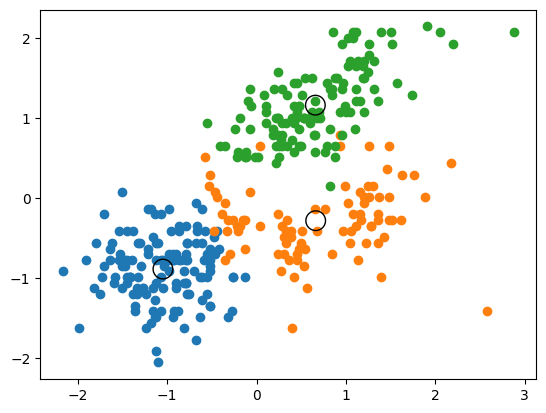

In [91]:
# Your code here
import csv
from pathlib import Path

def read_from_csv(csv_file_path: Path | str, delimiter: str):
    with open(csv_file_path, newline='') as csv_file:
        csv_reader = csv.reader(csv_file, delimiter=delimiter)
        header = next(csv_reader)
        content = []
        for x in csv_reader:
            content.append(x)
    return np.array(header), np.array(content)

def is_number(element):
    try:
        float(s)
        return True
    except ValueError:
        return False

def check_content_is_in_matrix(header, desired_values):
    check_list = []
    for i in range(len(header)):
        if header[i] in desired_values:
            check_list.append(True)
        else:
            check_list.append(False)
    return check_list
    

def replace_NA(X):
    for i in range(len(X)):
        for j in range(len(X[i])):
            if X[i][j] == 'NA':
                X[i][j] = np.nan
    return X
                

def normalize_data(X):
    length = len(X[1,:])

    X = np.array(X, dtype='f')
        
    for i in range(length):
        std = np.nanstd(X[:, i])
        mean = np.nanmean(X[:, i])
        for z in range(len(X[:, i])):
            X[:, i][z] = ((X[:, i][z] - mean)/std)
    return X

header, content = read_from_csv('palmer_penguins.csv', ',')
numeric_columns = np.array(['culmen_length_mm', 'culmen_depth_mm', 'flipper_length_mm', 'body_mass_g'])
check_list = check_content_is_in_matrix(header, numeric_columns)
content = replace_NA(content[:, check_list])
content = normalize_data(content)


k = 3
maxiter = 100
y, C = kmeans(content, k, maxiter)

# Gjør om dette til en liste med lister.
# Basert på k, dersom tid.
list_0 = content[y == 0]
list_1 = content[y == 1]
list_2 = content[y == 2]

plt.scatter(list_0[:, 0], list_0[:, 2])
plt.scatter(list_1[:, 0], list_1[:, 2])
plt.scatter(list_2[:, 0], list_2[:, 2])
#plt.scatter(X_clusters[closest_1, 0], X_clusters[closest_1, 1], label="Closest to c_1")

plt.scatter(
    C[:, 0],
    C[:, 2],
    marker="o",
    s=200,
    facecolors="none",
    edgecolors="k",
    label="new C",
)




Utifra resultatet ser det ut som at de blir gruppert greit, men nå har jeg ikke fått sjekket dette opp mot korrekt data.

Dersom jeg hadde fått tid ville jeg laget en test (slik som ble brukt på oppg 7), og testet effektiviteten basert på dette.
Fikk ikke tid til å konvertere Artene til nummer.
